In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

import gm2
import trfp
import helper_function_candidates as helper
import plotting_functions as plt2

Welcome to JupyROOT 6.12/04


In [2]:
# import all the fixed probe runs
# fp_moment_df = helper.import_fp_moment_runs('60hr_fixed_probe_runs.h5', range(3959, 3961))
fp_moment_df = helper.import_fp_moment_runs('60hr_fixed_probe_runs.h5', range(3959, 3995))

Appending fixed probe runs.
Appending run 3994.                              
Done appending fixed probe runs.


In [3]:
# import all trolley runs (keep CW run for baselines)
tr_moment_df_1, tr_single_runs_df_1 = helper.import_tr_moment_runs('60hr_trolley_runs_1.h5',
                                                                   range(3956, 3959),
                                                                   specific_runs=[3956],
                                                                   corrected=True)

tr_moment_df_2, tr_single_runs_df_2 = helper.import_tr_moment_runs('60hr_trolley_runs_2.h5',
                                                                   range(3995,3999),
                                                                   specific_runs=[3997, 3998],
                                                                   corrected=True)

tr_fixed_run_df = tr_single_runs_df_2[3997].iloc[:-20].append(tr_single_runs_df_2[3998].iloc[:17])
tr_fixed_run_df_corr = trfp.remove_trolley_effect(tr_fixed_run_df)

tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, summed_pts_1 = helper.trolley_run_station_average(tr_single_runs_df_1[3956])
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, summed_pts_2 = helper.trolley_run_station_average(tr_fixed_run_df_corr)

Appending corrected trolley runs.
Appending run 3956.
Finished removing trolley images from 4382 events.                                                            
Appending run 3957.
Finished removing trolley images from 2977 events.                                                            
Appending run 3958.
Finished removing trolley images from 539 events.              

Done appending corrected trolley runs.
Appending corrected trolley runs.
Appending run 3995.
Finished removing trolley images from 365 events.        
Appending run 3996.
Finished removing trolley images from 921 events.                       
Appending run 3997.
Finished removing trolley images from 4359 events.                                                            
Appending run 3998.
Finished removing trolley images from 2853 events.                                                            

Done appending corrected trolley runs.
Finished removing trolley images from 4356 events.                       

In [4]:
vtm_df_2 = helper.vtm_calc(fp_moment_df,
             baseline_time_1, baseline_time_2,
             tr_baseline_1, tr_baseline_2,
             fp_baseline_1, fp_baseline_2)

vtm_tr1_df = helper.vtm_calc(tr_moment_df_1,
             baseline_time_1, baseline_time_2,
             tr_baseline_1, tr_baseline_2,
             fp_baseline_1, fp_baseline_2)

vtm_tr2_df = helper.vtm_calc(tr_moment_df_2,
             baseline_time_1, baseline_time_2,
             tr_baseline_1, tr_baseline_2,
             fp_baseline_1, fp_baseline_2)

vtm_full_df = vtm_tr1_df.append(vtm_df_2, sort=False).append(vtm_tr2_df, sort=False)

In [5]:
### Bin into the agreed upon bins

bins = np.arange(1524384055, 1524641055, 1000)-500  # bin edges
bin_centers = np.arange(1524384055, 1524640055, 1000)

vtm_bin_df = vtm_full_df.groupby(pd.cut(vtm_full_df.index, bins)).mean()
vtm_bin_df.index = bin_centers
vtm_bin_df.head()
test_df = vtm_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

for m in range(5):
    weight = summed_azimuth_1[:, m] + summed_azimuth_2[:, m]
    total_weight = np.nansum(weight)
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight
    
print_df = azi_avg_df[['m1','m2','m3','m5']].copy()/61.79
print_df['m1_err'] = 0.116
print_df['m2_err'] = 0.06
print_df['m3_err'] = 0.06
print_df['m5_err'] = 0.1

print_df = print_df.sort_index(axis='columns')

print_df.head()

print_df.to_csv('purcell_60hr_7-3.csv')

m1    840.877276
m2      0.168550
m3      0.366048
m4      0.367730
m5     -1.258705
m6      0.000000
Name: 1524639055, dtype: float64


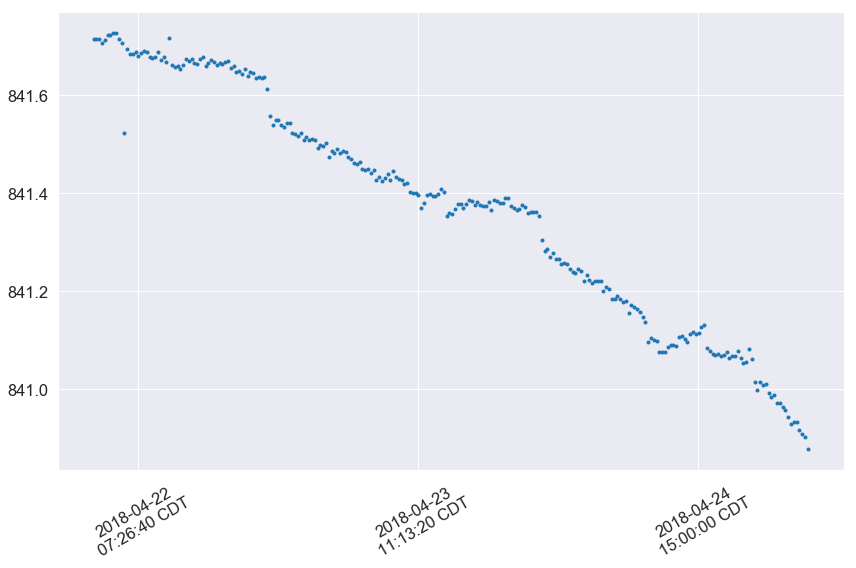

In [6]:
sns.set_style('darkgrid')

print  azi_avg_df.iloc[-1]/61.79

fig, ax = plt.subplots(1,1)
plt.sca(ax)
plt.plot(azi_avg_df.index.values, azi_avg_df['m1']/61.79, '.')
# plt.plot(vtm_df.index.values, vtm_df['st30,m1'], '.')

plt2.plt_unix_time_to_CST(ax)
fig.set_size_inches(12,8)
fig.tight_layout()

In [7]:
print np.nansum(tr_baseline_1[:,0]*summed_azimuth_1[:,0])/360
print np.nansum(tr_baseline_2[:,0]*summed_azimuth_2[:,0])/360

52010.48198418383
51954.6782179478


In [8]:
# ### Azimuthal averaging of the trolley runs.

# tr_cols = ['tr_phi'] + ['tr,m'+str(m+1) for m in range(17)]

# # azi_avg_df = tr_single_runs_df_1[3956][tr_cols].copy()
# # azi_avg_df = tr_single_runs_df_2[3997][tr_cols].copy()
# azi_avg_df = tr_fixed_run_df[tr_cols].copy()

# # sort by tr_phi
# azi_avg_df = azi_avg_df.sort_values(by=['tr_phi'])
# measured_phi = azi_avg_df['tr_phi'].values
# measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
# measured_extent[0] = measured_extent[0]+180
# measured_extent[-1] = measured_extent[-1]+180

# azi_avg_df['tr_extent'] = pd.Series(measured_extent, index=azi_avg_df.index)
# azi_avg_df = azi_avg_df.sort_index()
# # azi_avg_df = azi_avg_df.iloc[1:-1]

# print np.sum((azi_avg_df['tr_extent'].values * azi_avg_df['tr,m1'].values))/np.sum(azi_avg_df['tr_extent'].values)

# # mask a chunk, and calculate the weighted average in that chunk
# chunk_size = 45
# chunks = np.arange(262.226, 262.226-360.-chunk_size, -chunk_size)%360
# # chunks = np.arange(0,360,chunk_size)

# avg_m1 = np.empty(len(chunks)-1)

# ii=0
# for chunk in chunks[0:-1]:
#     if chunks[ii] > chunks[ii+1]:
#         mask = (azi_avg_df['tr_phi'] <= chunk) & (azi_avg_df['tr_phi'] > chunk - chunk_size)
#     else:
#         mask = (azi_avg_df['tr_phi'] <= chunk) | (azi_avg_df['tr_phi'] > (chunk - chunk_size)%360)
# #     mask = (azi_avg_df['tr_phi'] >= chunk) & (azi_avg_df['tr_phi'] < chunk + chunk_size)
#     masked_df = azi_avg_df[mask].copy()
#     avg_m1[ii] = np.sum((masked_df['tr_extent'].values * masked_df['tr,m1'].values))/np.sum(masked_df['tr_extent'].values)
# #     avg_m1[ii] = np.mean(masked_df['tr,m1'].values)
#     ii += 1

# print np.round(avg_m1/61.79,4)
# print np.round(np.mean(avg_m1)/61.79,4)

# # rachels = [827.158, 843.35, 832.939, 840.858, 839.643, 848.998, 847.843, 844.759, 855.821, 851.28, 834.809, 833.256]
# # rachels = [853.423, 839.411, 841.514, 843.103, 846.196, 854.245, 860.909, 849.704, 836.338, 824.734, 843.18, 850.953, 835.783, 839.038, 847.717, 826.173, 828.564, 844.066, 850.029, 838.228, 841.825, 837.977, 827.122, 816.239, 842.408, 842.648, 814.754, 830.901, 841.447, 832.1, 860.263, 847.409, 846.18, 864.561, 844.672, 858.153]
# # rachels = [847.211, 837.801, 834.578, 847.358]
# rachels = [848.295, 848.26, 831.263, 832.374, 836.94, 828.263, 846.873, 854.249+0.120]

# print np.mean(rachels)
# print np.mean(avg_m1/61.79)
# print np.mean(rachels - avg_m1/61.79)
# print np.std(rachels - avg_m1/61.79)

# fig, ax = plt.subplots(2,1)
# plt.sca(ax[0])
# plt.plot(avg_m1/61.79, rachels, '.', color='red')

# plt.sca(ax[1])
# plt.plot(rachels - avg_m1/61.79, '.', color='red')

# fig.set_size_inches(12,8)
# fig.tight_layout()

In [9]:
# ### NOTE: This cell has been incorporated in helper functions.

# vtm_df = fp_moment_df.copy()

# for st in range(72):
#     num_probes = trfp.STATION_PROBE_NUMBER[st]

#     if num_probes == 4:
#         num_moments = 4
#         if st == 41: J = trfp.J_4_PROBE_ST41
#         elif st == 37 | st == 39: J = trfp.J_4_PROBE_ST37_ST39
#         else: J = trfp.J_4_PROBE
#     else:
#         num_moments = 5
#         if st < 7: J = trfp.J_6_PROBE_OFFSET
#         else: J = trfp.J_6_PROBE
# #         J[0,4] = 0

#     # first subtract fixed probe baseline from vtm_df
#     for m in range(num_probes):
#         stm = 'st'+str(st)+',m'+str(m+1)

#         def __backwards_correction(time):
#             c1 = fp_baseline_1[st, m]
#             c2 = fp_baseline_2[st, m]
#             t1 = baseline_time_1[st, m]
#             t2 = baseline_time_2[st, m]
#             return (c2-c1)/(t2-t1)*(time-t1) + c1

#         vtm_df[stm] = vtm_df[stm] - __backwards_correction(vtm_df.index.values)

#     # next apply the Jacobian to the station
#     stms = ['st'+str(st)+',m'+str(m+1) for m in range(num_moments)]
#     vtm_df[stms] = vtm_df[stms].dot(np.transpose(J))

#     # finally add trolley baseline to vtm_df
#     for m in range(num_probes):
#         stm = 'st'+str(st)+',m'+str(m+1)

#         def __backwards_correction(time):
#             c1 = tr_baseline_1[st, m]
#             c2 = tr_baseline_2[st, m]
#             t1 = baseline_time_1[st, m]
#             t2 = baseline_time_2[st, m]
#             return (c2-c1)/(t2-t1)*(time-t1) + c1

#         vtm_df[stm] = vtm_df[stm] + __backwards_correction(vtm_df.index.values)

# print '\nDone.'
